1. START DATE: 04/08/25
2. GOAL: To build an unsupervised model to segment households that fear they will be unable to get credit.
3. DATA SOURCE: 2019 consumer finance data from the US Federal Reserve

#### PROJECT OVERVIEW
This project explores U.S. household finance data using clustering techniques. I will analyze small business and credit-fearful households, apply k-means with standardized features, evaluate models using inertia and silhouette scores, and visualize results with PCA. The project ends with building an interactive dashboard and a deployable clustering pipeline.

#### OBJECTIVES
1. Compare characteristics across subgroups using a side-by-side bar chart.
2. Build a k-means clustering model.
3. Conduct feature selection for clustering based on variance.
4. Reduce high-dimensional data using principal component analysis (PCA).
5. Design, build and deploy a Dash web application.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Load Data
df= pd.read_csv("data/SCFP2019.csv.gz")
print("data type:", type(df))
print("data shape:", df.shape)
df.head()

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (28885, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


In [5]:
#Subset Data  to only households that have been turned down or feared being turned down for credit ("TURNFEAR" == 1)
mask = df["TURNFEAR"] == 1
df_fear = df[mask]
print("df_fear type:", type(df_fear))
print("df_fear shape:", df_fear.shape)
df_fear.head()

df_fear type: <class 'pandas.core.frame.DataFrame'>
df_fear shape: (4623, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


In [8]:
#Explore
#I'm going to explore some of the features, i'll start with the "AGECL"columm
#(no specific reason for picking this feature among others)
df_fear["AGECL"].nunique()

6

In [9]:
age_groups = df_fear["AGECL"].unique()
print("Age Groups:", age_groups)

Age Groups: [3 5 1 2 4 6]


From the code book in our data dictionary, you can find the 6 unique age classifications (AGECL)
1. 1 represents <35 years
2. 2 represents 35-44 years
3. 3 represents 45-54 years
4. 4 represents 55-64 years
5. 5 represents 65-74 years
6. 6 represents >= 75 years

In [11]:
# Create a Series "agecl"that contains the observations from "AGECL" using the true group names.
agecl_dict = {
    1: "Under 35",
    2: "35-44",
    3: "45-54",
    4: "55-64",
    5: "65-74",
    6: "75 or Older",
}

age_cl = df_fear["AGECL"].replace(agecl_dict)
print("age_cl type:", type(age_cl))
print("age_cl shape:", age_cl.shape)
age_cl.head()

age_cl type: <class 'pandas.core.series.Series'>
age_cl shape: (4623,)


5    45-54
6    45-54
7    45-54
8    45-54
9    45-54
Name: AGECL, dtype: object

In [12]:
#Visual (bar chart) to see the age distribution of our group.
age_cl.value_counts()

AGECL
Under 35       1307
35-44          1093
45-54           932
55-64           745
65-74           401
75 or Older     145
Name: count, dtype: int64

##### Note:
The chart shows that many of the people who fear being denied credit are younger. But the first two age groups cover a wider range than the other four. So it might be important to take a closer look at the individual ages in each category in order to have a broader understanding of the data.

I'll explore a different variable: "AGE". Whereas "AGECL" was a categorical variable, "AGE" is continuous.

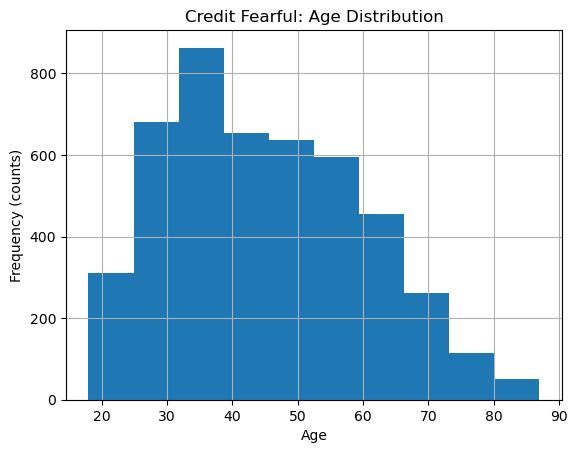

In [14]:
# Plot histogram of "AGE"
df_fear["AGE"].hist(bins=10)
plt.xlabel("Age"),
plt.ylabel("Frequency (counts)"),
plt.title("Credit Fearful: Age Distribution");

##### Note:
From the histogram, it showed that tge credit fear covered a larger age group from age 26 to 65 and not just under 35 age group. The most concerned seem to be between age 30-40

##### Explore another feature "RACE"

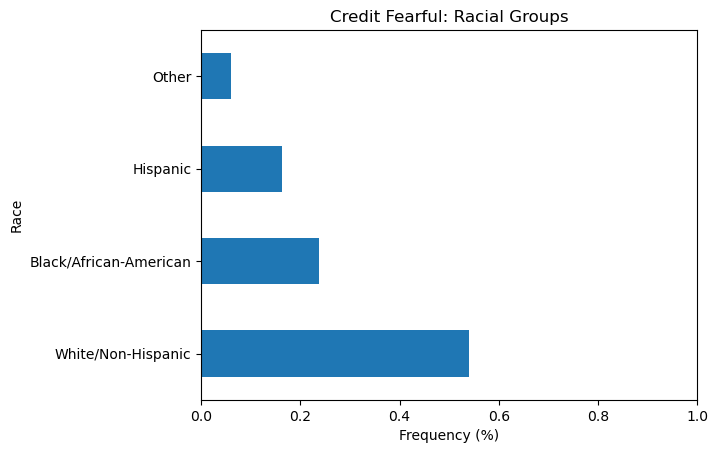

In [15]:
race_dict = {
    1: "White/Non-Hispanic",
    2: "Black/African-American",
    3: "Hispanic",
    5: "Other",
}
race = df_fear["RACE"].replace(race_dict)
race_value_counts = race.value_counts(normalize=True)
# Create bar chart of race_value_counts
race_value_counts.plot(
    kind="barh"
)
plt.xlim((0, 1))
plt.xlabel("Frequency (%)")
plt.ylabel("Race")
plt.title("Credit Fearful: Racial Groups");

##### Observation:
It appears that the white/non-Hispanic race seem to face credit fear more.But it's hard to jump into conclusion just like that, we might find something interesting if we take a closer look. 
What if I check the complte data set 

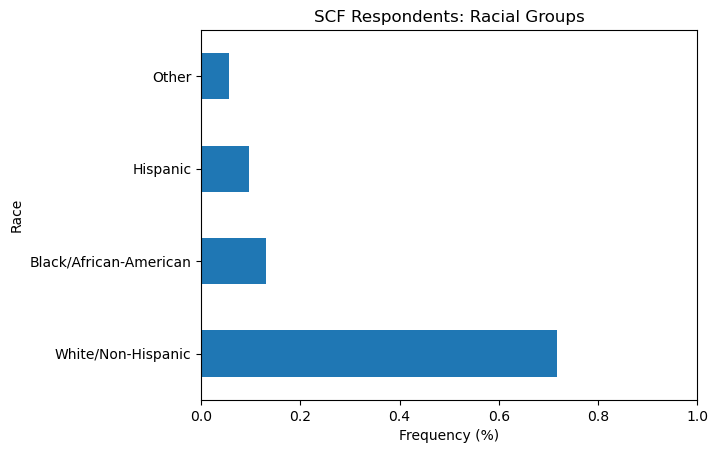

In [16]:
race = df["RACE"].replace(race_dict)
race_value_counts = race.value_counts(normalize=True)
# Create bar chart of race_value_counts
race_value_counts.plot(kind="barh")
plt.xlim((0, 1))
plt.xlabel("Frequency (%)")
plt.ylabel("Race")
plt.title("SCF Respondents: Racial Groups");

##### Observation: 
Generally the white/non-Hispanic race have the highest population covering about 70% of the total population. So it makes sense if white race is highly represented in the credit fear group (only 54% of credit fearful respondents). This doesn't mean their race was what contributed to this based on propertion. On the other hand, Black and Hispanic respondents represent 23% of the whole dataset but 40% of credit fearful respondents. In other words, Black and Hispanic households are actually more likely to be in the credit fearful group.

Another intersting thing to consider is that wouldn't it be an offence to use an individual's "RACE" to determine if he or she gets qualified for a credit card? So maybe "RACE" might not be an important feature. We'll discover this with time

In [18]:
#Explore income feature "INCCAT"
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}

df_inccat = (
    df["INCCAT"]
    .replace(inccat_dict)
    .groupby(df["TURNFEAR"])
    .value_counts(normalize=True)
    .rename("frequency")
    .to_frame()
    .reset_index()
)


print("df_inccat type:", type(df_inccat))
print("df_inccat shape:", df_inccat.shape)
df_inccat

df_inccat type: <class 'pandas.core.frame.DataFrame'>
df_inccat shape: (12, 3)


,TURNFEAR,INCCAT,frequency
0,0,90-100,0.297296
1,0,60-79.9,0.174841
2,0,40-59.9,0.143146
3,0,0-20,0.140343
4,0,21-39.9,0.135933
5,0,80-89.9,0.108441
6,1,0-20,0.288125
7,1,21-39.9,0.256327
8,1,40-59.9,0.228856
9,1,60-79.9,0.132598


In [ ]:
# Create bar chart of `df_inccat`
sns.barplot(
    x="INCCAT",
    y= "frequency",
    hue= "TURNFEAR",
    data=df_inccat,
    order=inccat_dict.values()
)
plt.xlabel("Income Category")
plt.ylabel("Frequency (%)")
plt.title("Income Distribution: Credit Fearful vs. Non-fearful");

Comparing the income categories across the fearful and non-fearful groups, we can see that credit fearful households are much more common in the lower income categories. In other words, the credit fearful have lower incomes.

###### Let's explore another feature "ASSET".
It makes sense to explore the asset feature for both credit fearful and non-credit fearful individuals because any financial institution would probably care less about how old a person is or their race, rather more attention would be paid to their ability to carry more debt (which can be measured by their asset).

It will make sense to establish some relationships among the variables, and making some correlation matrices

In [20]:
asset_house_corr = df["ASSET"].corr(df["HOUSES"])
print("SCF: Asset Houses Correlation:", asset_house_corr)
#SCF represents Sample Correlation Function

SCF: Asset Houses Correlation: 0.5198273544779252


In [22]:
#Correlation matrix using df, considering only the columns "ASSET", "HOUSES", "INCOME", "DEBT", and "EDUC".
cols = ["ASSET", "HOUSES", "INCOME", "DEBT", "EDUC"]
corr = df[cols].corr()
corr.style.background_gradient(axis=None)

,ASSET,HOUSES,INCOME,DEBT,EDUC
ASSET,1.000000,0.519827,0.622429,0.261250,0.116673
HOUSES,0.519827,1.000000,0.247852,0.266661,0.169300
INCOME,0.622429,0.247852,1.000000,0.114646,0.069400
DEBT,0.261250,0.266661,0.114646,1.000000,0.054179
EDUC,0.116673,0.169300,0.069400,0.054179,1.000000


In [23]:
#Ccorrelation matrix using df_fear
corr = df_fear[cols].corr()
corr.style.background_gradient(axis=None)

,ASSET,HOUSES,INCOME,DEBT,EDUC
ASSET,1.000000,0.583288,0.722074,0.474658,0.113536
HOUSES,0.583288,1.000000,0.264099,0.962629,0.160348
INCOME,0.722074,0.264099,1.000000,0.172393,0.133170
DEBT,0.474658,0.962629,0.172393,1.000000,0.177386
EDUC,0.113536,0.160348,0.133170,0.177386,1.000000


In [24]:
#Explore "EDUCATION" feature 
df_educ = (
    df["EDUC"]
    .groupby(df["TURNFEAR"])
    .value_counts(normalize=True)
    .rename("frequency")
    .to_frame()
    .reset_index()
)

print("df_educ type:", type(df_educ))
print("df_educ shape:", df_educ.shape)
df_educ.head()

df_educ type: <class 'pandas.core.frame.DataFrame'>
df_educ shape: (30, 3)


,TURNFEAR,EDUC,frequency
0,0,12,0.257481
1,0,8,0.192029
2,0,13,0.149823
3,0,9,0.129833
4,0,14,0.096117


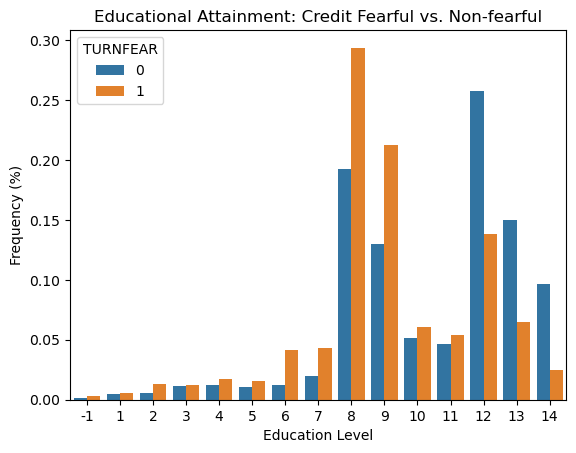

In [25]:
# Create bar chart of `df_educ`
sns.barplot(
    x="EDUC",
    y="frequency",
    hue= "TURNFEAR",
    data= df_educ
)
plt.xlabel("Education Level")
plt.ylabel("Frequency (%)")
plt.title("Educational Attainment: Credit Fearful vs. Non-fearful");

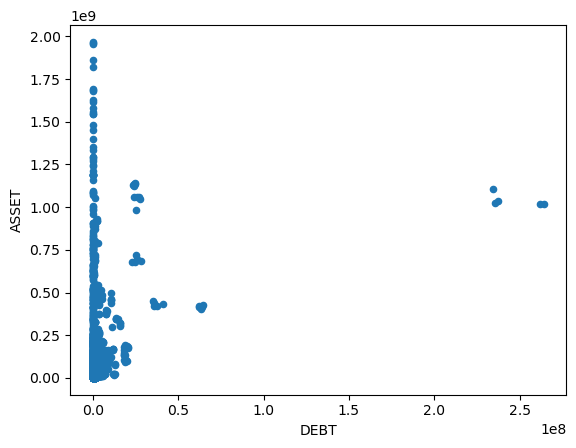

In [26]:
# Create scatter plot of ASSET vs DEBT, df
df.plot.scatter(x="DEBT", y="ASSET");

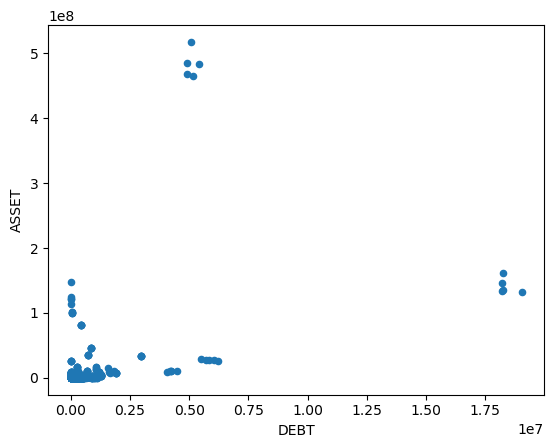

In [27]:
# Create scatter plot of ASSET vs DEBT, df_fear
# Create scatter plot of ASSET vs DEBT, df
df_fear.plot.scatter(x="DEBT", y="ASSET");

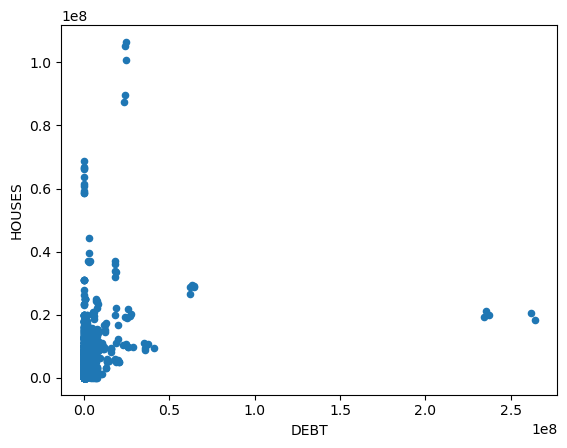

In [28]:
# Create scatter plot of HOUSES vs DEBT, df
df.plot.scatter(x="DEBT", y="HOUSES");

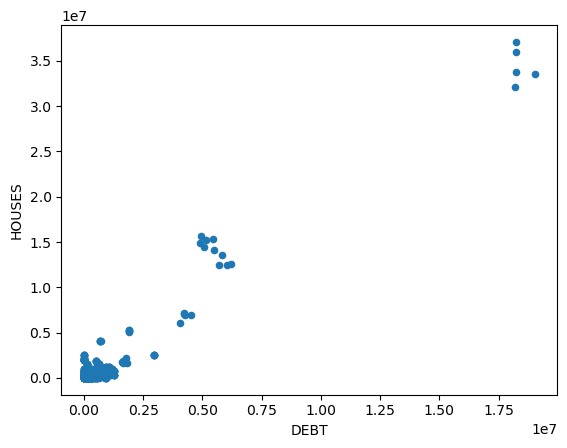

In [30]:
# Create scatter plot of HOUSES vs DEBT, df_fear
df_fear.plot.scatter(x="DEBT", y="HOUSES");